1 Imports

In [1]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


2 Combine CSV file and remove duplicates

In [2]:
import pandas as pd
import glob
import os

# Path to the folder where the CSV files are located
folder = r"C:\Users\dudam\OneDrive\Área de Trabalho\AI Engineering\W6\D2\automated-customer-reviews\dataset_duda"

# Find all .csv files in the folder
files = glob.glob(os.path.join(folder, "*.csv"))

print(f"Files found: {files}")

# Read and combine all CSV files
df = pd.concat([pd.read_csv(f) for f in files])

# Remove duplicate rows
df = df.drop_duplicates()

# Save the result to a new CSV file
df.to_csv(os.path.join(folder, "data_uni.csv"), index=False)

print(" All CSV files combined and duplicates removed!")


Files found: ['C:\\Users\\dudam\\OneDrive\\Área de Trabalho\\AI Engineering\\W6\\D2\\automated-customer-reviews\\dataset_duda\\data1.csv', 'C:\\Users\\dudam\\OneDrive\\Área de Trabalho\\AI Engineering\\W6\\D2\\automated-customer-reviews\\dataset_duda\\data2.csv', 'C:\\Users\\dudam\\OneDrive\\Área de Trabalho\\AI Engineering\\W6\\D2\\automated-customer-reviews\\dataset_duda\\data3.csv', 'C:\\Users\\dudam\\OneDrive\\Área de Trabalho\\AI Engineering\\W6\\D2\\automated-customer-reviews\\dataset_duda\\data_uni.csv']


C:\Users\dudam\AppData\Local\Temp\ipykernel_25536\2400639447.py:14: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in files])
C:\Users\dudam\AppData\Local\Temp\ipykernel_25536\2400639447.py:14: DtypeWarning: Columns (10,11,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in files])


 All CSV files combined and duplicates removed!


3 Build text field (title + text)

In [3]:
TEXT_COL = "reviews.text"
TITLE_COL = "reviews.title"
RATING_COL = "reviews.rating"

# Combine title + text into one field
df["full_review"] = df[TITLE_COL].fillna('') + ". " + df[TEXT_COL].fillna('')


4 Map rating → sentiment label

In [4]:
def map_rating_to_label(r):
    if pd.isna(r):
        return None
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["label"] = df[RATING_COL].apply(map_rating_to_label)

# Keep only what we need
df_sent = df[["full_review", "label"]].dropna(subset=["label"]).copy()


5 Clean the text 

In [5]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"<.*?>", " ", text)                  # remove HTML
    text = re.sub(r"http\S+|www\.\S+", " ", text)       # remove URLs
    text = re.sub(r"\s+", " ", text).strip()            # normalize spaces
    return text

df_sent["clean_text"] = df_sent["full_review"].apply(clean_text)

# Drop empty after cleaning
df_sent = df_sent[df_sent["clean_text"].str.len() > 0]


6 Train/Test split (stratified)

In [6]:
X = df_sent["clean_text"]
y = df_sent["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


7 TF-IDF (tuned)

In [7]:
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 3),   # unigrams, bigrams, trigrams
    min_df=2,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


8 Train LinearSVC

In [8]:
svm_model = LinearSVC(
    class_weight='balanced',  # handle imbalance
    C=0.5,                    # you can tune this; 0.5 worked well for you
    random_state=42
)

svm_model.fit(X_train_tfidf, y_train)


LinearSVC(C=0.5, class_weight='balanced', random_state=42)

9 Evaluate

              precision    recall  f1-score   support

    negative      0.782     0.752     0.767       501
     neutral      0.635     0.557     0.593       580
    positive      0.976     0.983     0.980     12492

    accuracy                          0.957     13573
   macro avg      0.798     0.764     0.780     13573
weighted avg      0.955     0.957     0.956     13573



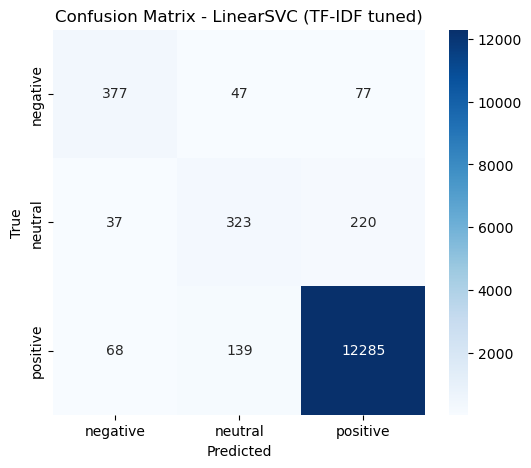

In [9]:
y_pred = svm_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred,
                      labels=["negative", "neutral", "positive"])

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LinearSVC (TF-IDF tuned)")
plt.show()


10 CSV file with labels

In [ ]:
#add the output folder
folder = "../outputs"
os.makedirs(folder, exist_ok=True)

In [23]:
# 10 Save a .csv file with the original data + sentiment column

# Merge the sentiment labels and clean_text back into the original dataframe
df["clean_text"] = df["full_review"].apply(clean_text)
df["sentiment"] = df["label"]  # rename for clarity

# Save final output
output_path = os.path.join(folder, r"data_with_sentiment.csv")
df.to_csv(output_path, index=False)

print(f"File saved successfully to: {output_path}")


File saved successfully to: ../outputs\data_with_sentiment.csv


11 Save model & vectorizer

In [11]:
import joblib

joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(svm_model, "sentiment_svm_model.pkl")


['sentiment_svm_model.pkl']

12 Error type table

In [12]:
# Create a DataFrame with test data, true labels, and predictions
results_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "predicted_label": y_pred
}).reset_index(drop=True)

# Filter only the misclassified ones
misclassified_df = results_df[results_df["true_label"] != results_df["predicted_label"]].copy()

# Optional: add a column to see which type of error
misclassified_df["error_type"] = misclassified_df["true_label"] + " → " + misclassified_df["predicted_label"]

# Show top 20 examples for quick inspection
misclassified_df.head(20)


,text,true_label,predicted_label,error_type
29,"nice to look at, but may not last very long. b...",neutral,negative,neutral → negative
41,i put these in some battery powered candles fo...,positive,negative,positive → negative
42,needs more fluent data knowledge. data is tied...,neutral,positive,neutral → positive
54,just ok. owned roku for years. bought fire tv ...,neutral,positive,neutral → positive
55,quantity over quality.. i think the price is r...,neutral,positive,neutral → positive
79,wish they had been better!. these don't last l...,negative,positive,negative → positive
93,not worth the extra money. rather would have t...,neutral,positive,neutral → positive
161,daughter seems to really like 1st non-android ...,positive,neutral,positive → neutral
186,kindle review.. there have been a few minor ch...,neutral,positive,neutral → positive
207,"it worked 30 minutes, shut off and won‚äôt sta...",negative,positive,negative → positive


In [13]:
misclassified_df.to_csv("misclassified_reviews.csv", index=False)
print(f"Saved {len(misclassified_df)} misclassified samples to misclassified_reviews.csv")


Saved 588 misclassified samples to misclassified_reviews.csv


In [14]:
print(misclassified_df["error_type"].value_counts())


error_type
neutral → positive     220
positive → neutral     139
negative → positive     77
positive → negative     68
negative → neutral      47
neutral → negative      37
Name: count, dtype: int64


In [15]:
# Re-load original full dataset
df_original = pd.read_csv(os.path.join(folder, "data_uni.csv"))


C:\Users\dudam\AppData\Local\Temp\ipykernel_25536\625627043.py:2: DtypeWarning: Columns (10,11,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(os.path.join(folder, "data_uni.csv"))


In [16]:
TEXT_COL = "reviews.text"
TITLE_COL = "reviews.title"
RATING_COL = "reviews.rating"

df_original["full_review"] = df_original[TITLE_COL].fillna('') + ". " + df_original[TEXT_COL].fillna('')
df_original["full_review"] = df_original["full_review"].str.lower().str.replace(r"\s+", " ", regex=True).str.strip()


In [17]:
# Suppose df_original also has a product ID column
PRODUCT_ID_COL = "id"

# Merge misclassified results with original data
merged_misclassified = misclassified_df.merge(
    df_original[[PRODUCT_ID_COL, TITLE_COL, TEXT_COL, RATING_COL, "full_review"]],
    how="left",
    left_on="text",
    right_on="full_review"
)


In [18]:
merged_misclassified = merged_misclassified[[
    PRODUCT_ID_COL,
    TITLE_COL,
    TEXT_COL,
    RATING_COL,
    "true_label",
    "predicted_label",
    "error_type"
]]


In [ ]:
# Show the first few misclassified examples with full details
merged_misclassified.head(20)

# Optionally save to CSV
merged_misclassified.to_csv(r"..\outputs\misclassified_detailed.csv", index=False)
print(f"Saved {len(merged_misclassified)} detailed misclassified samples to misclassified_detailed.csv")


Saved 667 detailed misclassified samples to misclassified_detailed.csv
